In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install jcopml

     |████████████████████████████████| 101 kB 4.0 MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.14-py2.py3-none-any.whl size=33655 sha256=6d05fe8e0b56ccfd50e8e70f443f6e745d5f5cb06882b2f13c1eecae51c3b020
  Stored in directory: /root/.cache/pip/wheels/d9/6a/86/9a622c06f65732afe0e31c02a92fae6ab663ffd7162bcf5125
Successfully built jcopml


# Formulation

1. Data
- Pada kasus ini yang ingin diprediksi adalah customer yang kemungkinan akan churn, serta berhenti menggunakan layanan dari aplikasi ecommerce.
- Customer yang kemungkinan akan churn dapat diprediksi berdasarkan data demografis user, perilaku user dalam bertransaksi, serta data lain yang mendukung.

2. ML Objective : objective dari ML ini adalah memaksimalkan revenue dari perusahaan, serta meminimalkan resiko churn untuk user lainnya di waktu yang akan datang.

3. Action : yang akan dilakukan setelah hasil prediksi diperoleh adalah menawarkan user yang teridentifikasi churn dengan program package promo yang sesuai untuk mereka.

4. Value : hasil yang ingin dicapai dari penggunaan model machine learning ini adalah meningkatnya revenue dari perusahaan dan meminimalisir kehilangan user dalam aplikasi kita.

# Import Data

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [4]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/finalProject Purwadhika/data/ECommerceDataset_clean.csv", index_col="CustomerID")
df.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
CustomerID,,,,,,,,,,,,,,,,,,,
50001,1,4,Mobile Phone,3,6,Debit Card,Female,3,3,Laptop & Accessory,2,Single,9,1,11,1,1,5,160
50002,1,10,Mobile Phone,1,8,UPI,Male,3,4,Mobile Phone,3,Single,7,1,15,0,1,0,121
50003,1,10,Mobile Phone,1,30,Debit Card,Male,2,4,Mobile Phone,3,Single,6,1,14,0,1,3,120
50004,1,0,Mobile Phone,3,15,Debit Card,Male,2,4,Laptop & Accessory,5,Single,8,0,23,0,1,3,134
50005,1,0,Mobile Phone,1,12,Credit Card,Male,2,3,Mobile Phone,5,Single,3,0,11,1,1,3,130


In [5]:
# percentage of the missing values
for col in df.columns:
    prct = np.mean(df[col].isnull())
    print('{}: {}%'.format(col, round(prct*100)))

Churn: 0%
Tenure: 0%
PreferredLoginDevice: 0%
CityTier: 0%
WarehouseToHome: 0%
PreferredPaymentMode: 0%
Gender: 0%
HourSpendOnApp: 0%
NumberOfDeviceRegistered: 0%
PreferedOrderCat: 0%
SatisfactionScore: 0%
MaritalStatus: 0%
NumberOfAddress: 0%
Complain: 0%
OrderAmountHikeFromlastYear: 0%
CouponUsed: 0%
OrderCount: 0%
DaySinceLastOrder: 0%
CashbackAmount: 0%


In [6]:
df.Churn.value_counts() / len(df)

0    0.831616
1    0.168384
Name: Churn, dtype: float64

Bisa kita lihat disini variabel target cukup imbalance datanya

In [7]:
df.shape

(5630, 19)

Berdasarkan dataset, terdapat 5630 data observasi.

# Collinearity

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
X = df[["CityTier", "Complain", "Tenure", "WarehouseToHome", "HourSpendOnApp", "NumberOfDeviceRegistered", "SatisfactionScore", "NumberOfAddress", "OrderAmountHikeFromlastYear", "CouponUsed", "OrderCount", "DaySinceLastOrder", "CashbackAmount"]]

In [10]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [11]:
calc_vif(X)

,variables,VIF
0,CityTier,4.162109
1,Complain,1.396940
2,Tenure,3.383425
3,WarehouseToHome,4.585056
4,HourSpendOnApp,19.676574
5,NumberOfDeviceRegistered,16.143622
6,SatisfactionScore,5.477362
7,NumberOfAddress,4.213789
8,OrderAmountHikeFromlastYear,14.854923
9,CouponUsed,5.372234


- VIF = 1, tidak ada korelasi antara variabel independen dengan variabel lain
- VIF melebihi dari 10 menunjukkan multikolinearitas yang tinggi antara variabel independen dengan variabel lainnya
https://bbs.binus.ac.id/management/2019/12/analisis-uji-asumsi-klasik/

Berikut nilai VIF yang perlu kita pertimbangkan dalam melakukan modeling, jika memungkinkan bisa kita drop fitur dibawah ini:
- HourSpendOnApp 19.676574
- NumberOfDeviceRegistered 16.143622
- OrderAmountHikeFromlastYear 14.854923
- CashbackAmount 22.911403

# Data Correlation

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

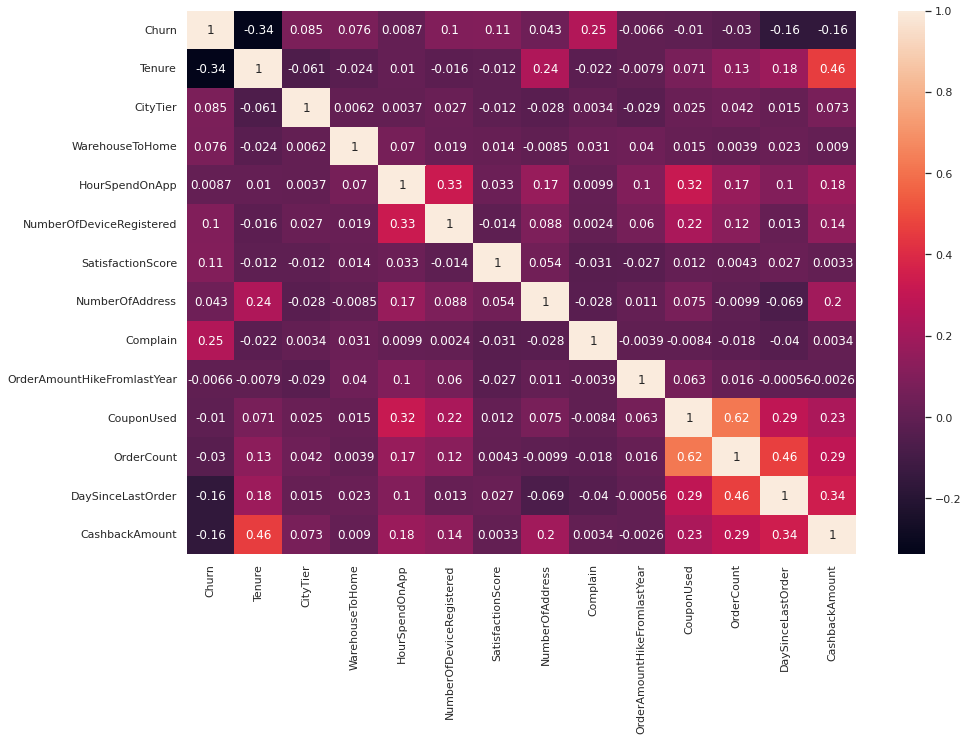

In [13]:
# let's check correlation
sns.set(rc={'figure.figsize':(15,10)})
corr = df.corr()
sns.heatmap(corr,annot=True)
plt.show()

CouponUsed dan OrderCount berkorelasi kuat, make sense karena setiap pengguna dengan lebih banyak kupon dapat memesan lebih banyak barang.<br>
Namun, itu hanya 0,62 jadi sementara bisa kita keep datanya.

# Dataset Splitting

1. Disini kita akan menggunakan churn sebagai variabel target(y) dan sisanya sebagai variabel fitur(X)
2. Kita akan gunakan random state 42, rasio splitting training dan testing 80:20.
3. Dalam kasus klasifikasi ini, kita melakukan stratify untuk variabel target(y)

In [14]:
X = df.drop(columns=['Churn'])
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4504, 18), (1126, 18), (4504,), (1126,))

# Training
Kita akan mencoba beberapa algoritma machine learning yang berbeda, Apapun modelnya, kita ingin model machine learning yang dapat menggeneralisasi dan memprediksi seakurat mungkin.

Dengan ColumnTransformer kita bisa membagi menjadi dua bagian pipa yaitu numeric dan categoric, dimana disetiap masing masing pipa terdapat perbedaan perlakuan terhadap suatu fitur.

### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [16]:
rsp.knn_params

{'algo__n_neighbors': Integer(low=1, high=40),
 'algo__p': Real(low=1, high=2, prior='uniform'),
 'algo__weights': ['uniform', 'distance']}

1. Disini kita akan memperlakukan fitur numerik dengan scaling minmax dan fitur kategorik dengan encoder onehot.
2. Kita akan gunakan algo KNeighborsClassifier.
3. Hyperparameter Tuning menggunakan RandomizedSearchCV, serta:
  - parameter dari n_neighbors, p, dan weights akan kita tuning.
  - cv=3 dan scoring='f1'

In [17]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax'), ["Tenure", "WarehouseToHome", "HourSpendOnApp", "NumberOfDeviceRegistered", "SatisfactionScore", "NumberOfAddress", "OrderAmountHikeFromlastYear", "CouponUsed", "OrderCount", "DaySinceLastOrder", "CashbackAmount"]),
    ('categoric', cat_pipe(encoder='onehot'), ["PreferredLoginDevice", "CityTier", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus", "Complain"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

modelKNN = RandomizedSearchCV(pipeline, rsp.knn_params, cv=3, scoring='f1', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
modelKNN.fit(X_train, y_train)

print(modelKNN.best_params_)
print(modelKNN.score(X_train, y_train), modelKNN.best_score_, modelKNN.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 10.6min finished


{'algo__n_neighbors': 1, 'algo__p': 1.1987156815341724, 'algo__weights': 'distance'}
1.0 0.8198028091601631 0.9147286821705426


Dari hasil score model disini bila kita lihat antara score dari train dan testnya masih cukup overfitting

### SVM

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [19]:
gsp.svm_params

{'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

1. Disini kita akan memperlakukan fitur numerik dengan scaling standard dan fitur kategorik dengan encoder onehot.
2. Kita akan gunakan algo SVC.
3. Hyperparameter Tuning menggunakan GridSearchCV dimana kita mencoba seluruh kombinasi dari hyperparameter, serta:
  - parameter dari C dan gamma akan kita tuning.
  - cv=3 dan scoring='f1'

In [20]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ["Tenure", "WarehouseToHome", "HourSpendOnApp", "NumberOfDeviceRegistered", "SatisfactionScore", "NumberOfAddress", "OrderAmountHikeFromlastYear", "CouponUsed", "OrderCount", "DaySinceLastOrder", "CashbackAmount"]),
    ('categoric', cat_pipe(encoder='onehot'), ["PreferredLoginDevice", "CityTier", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus", "Complain"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

modelSVM = GridSearchCV(pipeline, gsp.svm_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
modelSVM.fit(X_train, y_train)

print(modelSVM.best_params_)
print(modelSVM.score(X_train, y_train), modelSVM.best_score_, modelSVM.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   37.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 100.0, 'algo__gamma': 0.1}
0.9986824769433464 0.8287695263501714 0.9343832020997376


Dari hasil score model disini bila kita lihat antara score dari train dan testnya masih cukup overfitting

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [22]:
gsp.rf_params

{'algo__max_depth': [20, 50, 80],
 'algo__max_features': [0.3, 0.6, 0.8],
 'algo__min_samples_leaf': [1, 5, 10],
 'algo__n_estimators': [100, 150, 200]}

1. Disini kita tidak akan menerapkan scaling pada fitur numerik karena untuk algo dari tree sendiri itu akan sulit diinterpretasikan dan untuk fitur kategorik kita akan melakukan encode onehot.
2. Kita akan gunakan algo berbasis tree yaitu RandomForestClassifier.
3. Hyperparameter Tuning menggunakan GridSearchCV dimana kita mencoba seluruh kombinasi dari hyperparameter, serta:
  - parameter dari max_depth, max_features, min_samples_leaf, serta n_estimators akan kita tuning.
  - cv=3 dan scoring='f1'

In [23]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Tenure", "WarehouseToHome", "HourSpendOnApp", "NumberOfDeviceRegistered", "SatisfactionScore", "NumberOfAddress", "OrderAmountHikeFromlastYear", "CouponUsed", "OrderCount", "DaySinceLastOrder", "CashbackAmount"]),
    ('categoric', cat_pipe(encoder='onehot'), ["PreferredLoginDevice", "CityTier", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus", "Complain"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

modelRF = GridSearchCV(pipeline, gsp.rf_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
modelRF.fit(X_train, y_train)

print(modelRF.best_params_)
print(modelRF.score(X_train, y_train), modelRF.best_score_, modelRF.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  3.5min finished


{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 150}
1.0 0.8361592234011767 0.9651474530831098


Dari hasil score model disini bila kita lihat antara score dari train dan testnya masih cukup overfitting

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [25]:
gsp.logreg_params

{'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__fit_intercept': [True, False]}

1. Disini kita akan memperlakukan fitur numerik dengan scaling standard serta mentransform datanya dengan yeo-johnson agar distribusi dari data menjadi lebih normal dan untuk fitur kategorik kita lakukan dengan encoder onehot.
2. Kita akan gunakan algo LogisticRegression.
3. Pada LogisticRegression kita akan menambahkan solver='lbfgs', dimana sebagai optimizer dia bisa membantu kita untuk menuruni gradient yang kita tuju yaitu local minimum dengan cepat.
3. Hyperparameter Tuning menggunakan GridSearchCV dimana kita mencoba seluruh kombinasi dari hyperparameter, serta:
  - parameter dari C dan fit_intercept akan kita tuning.
  - cv=4

In [26]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson'), ["Tenure", "WarehouseToHome", "HourSpendOnApp", "NumberOfDeviceRegistered", "SatisfactionScore", "NumberOfAddress", "OrderAmountHikeFromlastYear", "CouponUsed", "OrderCount", "DaySinceLastOrder", "CashbackAmount"]),
    ('categoric', cat_pipe(encoder='onehot'), ["PreferredLoginDevice", "CityTier", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus", "Complain"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

modelLogReg = GridSearchCV(pipeline, gsp.logreg_params, cv=4, n_jobs=-1, verbose=1)
modelLogReg.fit(X_train, y_train)

print(modelLogReg.best_params_)
print(modelLogReg.score(X_train, y_train), modelLogReg.best_score_, modelLogReg.score(X_test, y_test))

Fitting 4 folds for each of 14 candidates, totalling 56 fits


/usr/local/lib/python3.7/dist-packages/jcopml/pipeline/_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    9.2s finished


{'algo__C': 0.1, 'algo__fit_intercept': True}
0.8967584369449378 0.896980461811723 0.8978685612788633


kita akan coba penggunaan fitur polynomial karena seringkali dapat meningkatkan performa model machine learning yang sifatnya linier seperti linear regression dan logistic regression.

In [27]:
rsp.logreg_poly_params

{'algo__C': Real(low=-3, high=3, prior='log-uniform'),
 'algo__fit_intercept': [True, False],
 'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False]}

In [28]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2, transform='yeo-johnson'), ["Tenure", "WarehouseToHome", "HourSpendOnApp", "NumberOfDeviceRegistered", "SatisfactionScore", "NumberOfAddress", "OrderAmountHikeFromlastYear", "CouponUsed", "OrderCount", "DaySinceLastOrder", "CashbackAmount"]),
    ('categoric', cat_pipe(encoder='onehot'), ["PreferredLoginDevice", "CityTier", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus", "Complain"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

modelLogReg = RandomizedSearchCV(pipeline, rsp.logreg_poly_params, cv=4, n_jobs=-1, verbose=1)
modelLogReg.fit(X_train, y_train)

print(modelLogReg.best_params_)
print(modelLogReg.score(X_train, y_train), modelLogReg.best_score_, modelLogReg.score(X_test, y_test))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/jcopml/pipeline/_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__C': 0.18358768367562223, 'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.9058614564831261 0.8996447602131438 0.9005328596802842


Disini kita mendapatkan score model yang sangat baik yaitu diangka 90% dan tidak terjadi overfitting. Selanjutkan kita akan melakukan evaluasi dari model yang sudah kita buat.

# Modelling, Collinearity

drop fitur dibawah ini:
- HourSpendOnApp 19.676574
- NumberOfDeviceRegistered 16.143622
- OrderAmountHikeFromlastYear 14.854923
- CashbackAmount 22.911403

# Training -> Collinearity

In [29]:
X = df.drop(columns=['Churn', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'OrderAmountHikeFromlastYear', 'CashbackAmount'])
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4504, 14), (1126, 14), (4504,), (1126,))

In [30]:
X.columns

Index(['Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome',
       'PreferredPaymentMode', 'Gender', 'PreferedOrderCat',
       'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder'],
      dtype='object')

In [31]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2, transform='yeo-johnson'), ["Tenure", "WarehouseToHome", "SatisfactionScore", "NumberOfAddress", "CouponUsed", "DaySinceLastOrder", "OrderCount"]),
    ('categoric', cat_pipe(encoder='onehot'), ["PreferredLoginDevice", "CityTier", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus", "Complain"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

modelLogRegC = RandomizedSearchCV(pipeline, rsp.logreg_poly_params, cv=4, n_jobs=-1, verbose=1)
modelLogRegC.fit(X_train, y_train)

print(modelLogRegC.best_params_)
print(modelLogRegC.score(X_train, y_train), modelLogRegC.best_score_, modelLogRegC.score(X_test, y_test))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/jcopml/pipeline/_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__C': 0.5271733051785579, 'algo__fit_intercept': False, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.8994227353463587 0.8954262877442273 0.8960923623445826


Terlihat disini kita mencoba drop fitur yang memiliki nilai VIF lebih dari 10, ternyata fitur yang berkolinearitas tinggi tidak terlalu signifikan membuat model improve.

# Fix Modeling

In [32]:
X = df.drop(columns=['Churn'])
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4504, 18), (1126, 18), (4504,), (1126,))

In [33]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2, transform='yeo-johnson'), ["Tenure", "WarehouseToHome", "HourSpendOnApp", "NumberOfDeviceRegistered", "SatisfactionScore", "NumberOfAddress", "OrderAmountHikeFromlastYear", "CouponUsed", "OrderCount", "DaySinceLastOrder", "CashbackAmount"]),
    ('categoric', cat_pipe(encoder='onehot'), ["PreferredLoginDevice", "CityTier", "PreferredPaymentMode", "Gender", "PreferedOrderCat", "MaritalStatus", "Complain"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

modelLogReg = RandomizedSearchCV(pipeline, rsp.logreg_poly_params, cv=4, n_jobs=-1, verbose=1)
modelLogReg.fit(X_train, y_train)

print(modelLogReg.best_params_)
print(modelLogReg.score(X_train, y_train), modelLogReg.best_score_, modelLogReg.score(X_test, y_test))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/jcopml/pipeline/_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   41.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__C': 1.1667820037046877, 'algo__fit_intercept': False, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.9065275310834814 0.900088809946714 0.9005328596802842


# Evaluation

In [34]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve, plot_pr_curve

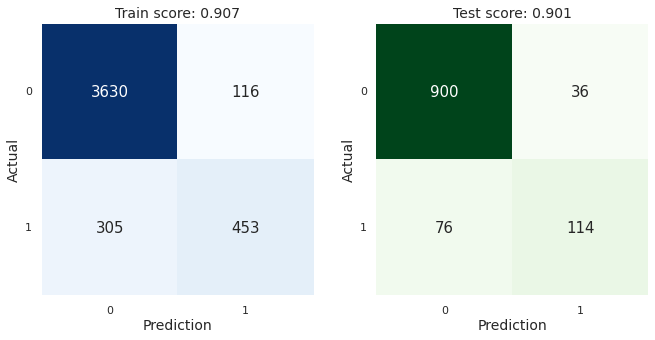

In [35]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, modelLogReg)

In [36]:
plot_classification_report(X_train, y_train, X_test, y_test, modelLogReg, report=True)

Train report
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      3746
           1       0.80      0.60      0.68       758

    accuracy                           0.91      4504
   macro avg       0.86      0.78      0.81      4504
weighted avg       0.90      0.91      0.90      4504


Test report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       936
           1       0.76      0.60      0.67       190

    accuracy                           0.90      1126
   macro avg       0.84      0.78      0.81      1126
weighted avg       0.89      0.90      0.90      1126



In [38]:
from sklearn.metrics import roc_auc_score

In [39]:
# predict probabilities
pred_prob = modelLogReg.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)

0.8994152046783626


Dilihat dari AUC score kita mendapatkan score 89, jika nilai dari AUC kita terlalu kecil maka kita perlu melakukan resampling data.

Disini kita tidak perlu melakukan resampling data, karena business problem kita kedua kelas sama pentingnya baik kelas positif maupun negatif. Jadi, semakin tinggi nilai AUC suatu classifier, semakin baik kemampuannya untuk membedakan antara kelas positif dan negatif.

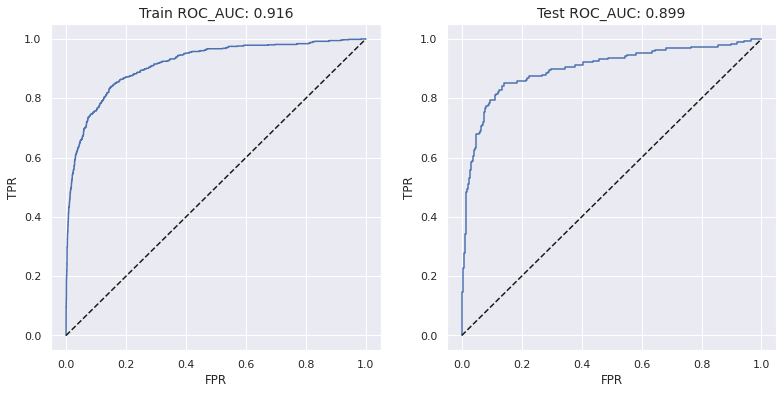

In [40]:
plot_roc_curve(X_train, y_train, X_test, y_test, modelLogReg)

Ketika AUC = 1, maka classifier mampu membedakan dengan sempurna antara semua poin kelas Positif dan Negatif dengan benar. Namun, jika AUC adalah 0, maka classifier akan memprediksi semua Negatif sebagai Positif, dan semua Positif sebagai Negatif.

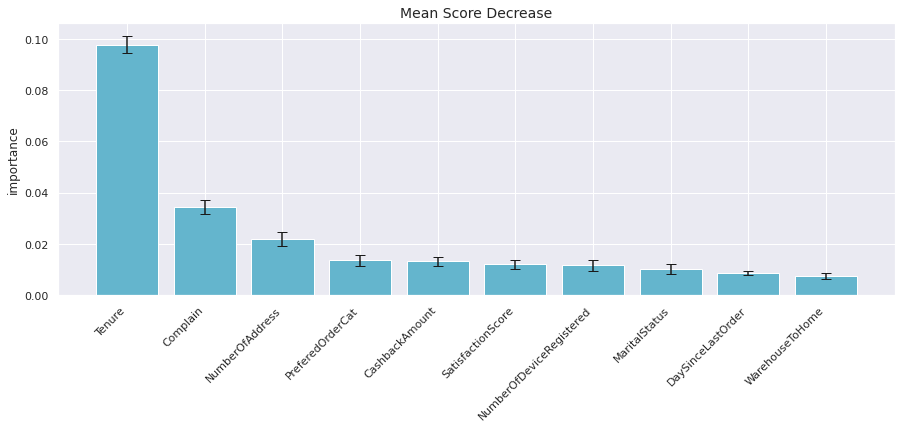

In [41]:
# Feature Importance
df_imp = mean_score_decrease(X_train, y_train, modelLogReg, plot=True, topk=10)

### model with Feature Importance

In [44]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2, transform='yeo-johnson'), ["Tenure", "WarehouseToHome", "NumberOfDeviceRegistered", "SatisfactionScore", "NumberOfAddress", "DaySinceLastOrder", "CashbackAmount"]),
    ('categoric', cat_pipe(encoder='onehot'), ["PreferedOrderCat", "MaritalStatus", "Complain"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

modelLogReg = RandomizedSearchCV(pipeline, rsp.logreg_poly_params, cv=4, n_jobs=-1, verbose=1)
modelLogReg.fit(X_train, y_train)

print(modelLogReg.best_params_)
print(modelLogReg.score(X_train, y_train), modelLogReg.best_score_, modelLogReg.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/jcopml/pipeline/_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__C': 99.85700038967089, 'algo__fit_intercept': True, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.8923179396092362 0.8898756660746004 0.8952042628774423


kita akan gunakan variabel dari fitur importance, karena dengan fitur importance saja model kita sudah menghasilkan score yang sama baiknya dengan model yang kita masukan semua fitur. Selanjutnya kita coba tuning the hyperparameters grid search untuk memilih kombinasi model terbaik.

### select the best model using GridSearchCV

In [50]:
gsp.logreg_poly_params

{'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__fit_intercept': [True, False],
 'prep__numeric__poly__degree': [1, 2, 3],
 'prep__numeric__poly__interaction_only': [True, False]}

In [49]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2, transform='yeo-johnson'), ["Tenure", "WarehouseToHome", "NumberOfDeviceRegistered", "SatisfactionScore", "NumberOfAddress", "DaySinceLastOrder", "CashbackAmount"]),
    ('categoric', cat_pipe(encoder='onehot'), ["PreferedOrderCat", "MaritalStatus", "Complain"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

modelLogReg = GridSearchCV(pipeline, gsp.logreg_poly_params, cv=4, n_jobs=-1, verbose=1)
modelLogReg.fit(X_train, y_train)

print(modelLogReg.best_params_)
print(modelLogReg.score(X_train, y_train), modelLogReg.best_score_, modelLogReg.score(X_test, y_test))

Fitting 4 folds for each of 84 candidates, totalling 336 fits


/usr/local/lib/python3.7/dist-packages/jcopml/pipeline/_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:  2.6min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__C': 10.0, 'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.8976465364120781 0.8914298401420959 0.8960923623445826


In [51]:
# predict probabilities
pred_prob = modelLogReg.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)

0.8969073324336483


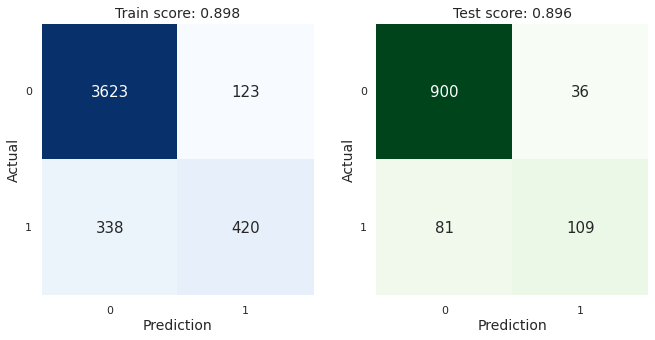

In [52]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, modelLogReg)

In [53]:
plot_classification_report(X_train, y_train, X_test, y_test, modelLogReg, report=True)

Train report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3746
           1       0.77      0.55      0.65       758

    accuracy                           0.90      4504
   macro avg       0.84      0.76      0.79      4504
weighted avg       0.89      0.90      0.89      4504


Test report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       936
           1       0.75      0.57      0.65       190

    accuracy                           0.90      1126
   macro avg       0.83      0.77      0.79      1126
weighted avg       0.89      0.90      0.89      1126



# Save Model

In [54]:
import pickle, os

In [57]:
os.makedirs("/content/drive/My Drive/Colab Notebooks/finalProject Purwadhika/model", exist_ok=True)

In [58]:
pickle.dump(modelLogReg, open("/content/drive/My Drive/Colab Notebooks/finalProject Purwadhika/model/logregChurn.pkl", "wb"))
pickle.dump(modelLogReg.best_estimator_, open("/content/drive/My Drive/Colab Notebooks/finalProject Purwadhika/model/logreg_smallChurn.pkl", "wb"))